In [85]:
%load_ext zipline
%load_ext watermark
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The zipline extension is already loaded. To reload it, use:
  %reload_ext zipline
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [86]:
import pandas as pd
import numpy as np
from collections import OrderedDict
import pytz

# необходимые функции zipline
from zipline.api import (order, record, symbol, set_benchmark, order_target_percent, get_open_orders, order_target, 
                        schedule_function, date_rules, time_rules, order_percent, symbols)

# комиссии
from zipline.finance import commission

# выбор календаря по которому происходит торговля
from trading_calendars.always_open import AlwaysOpenCalendar

import zipline

# графика
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

# работа с временем
from datetime import datetime, date

# aинансовые данные
from yahoofinancials import YahooFinancials

# ignore warnings
import warnings

# отчёт
import pyfolio as pf

# import helper functions 
import qf_helper_functions as qf

import pypfopt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

import pylab

from tqdm import tqdm

In [87]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [16, 4]
plt.rcParams['figure.dpi'] = 200
warnings.simplefilter(action='ignore', category=FutureWarning)

In [88]:
def download_csv_data(ticker, start_date, end_date, freq, path):
    
    yahoo_financials = YahooFinancials(ticker)

    df = yahoo_financials.get_historical_price_data(start_date, end_date, freq)
    df = pd.DataFrame(df[ticker]['prices']).drop(['date'], axis=1) \
            .rename(columns={'formatted_date':'date'}) \
            .loc[:, ['date','open','high','low','close', 'adjclose', 'volume']] \
            .set_index('date')
    df.index = pd.to_datetime(df.index)
    df['dividend'] = 0
    df['split'] = 1

    # save data to csv for later ingestion
    df.to_csv(path, header=True, index=True)

    # plot the time series
    df.close.plot(title='{} prices --- {}:{}'.format(ticker, start_date, end_date), color='green');

# Vanguard

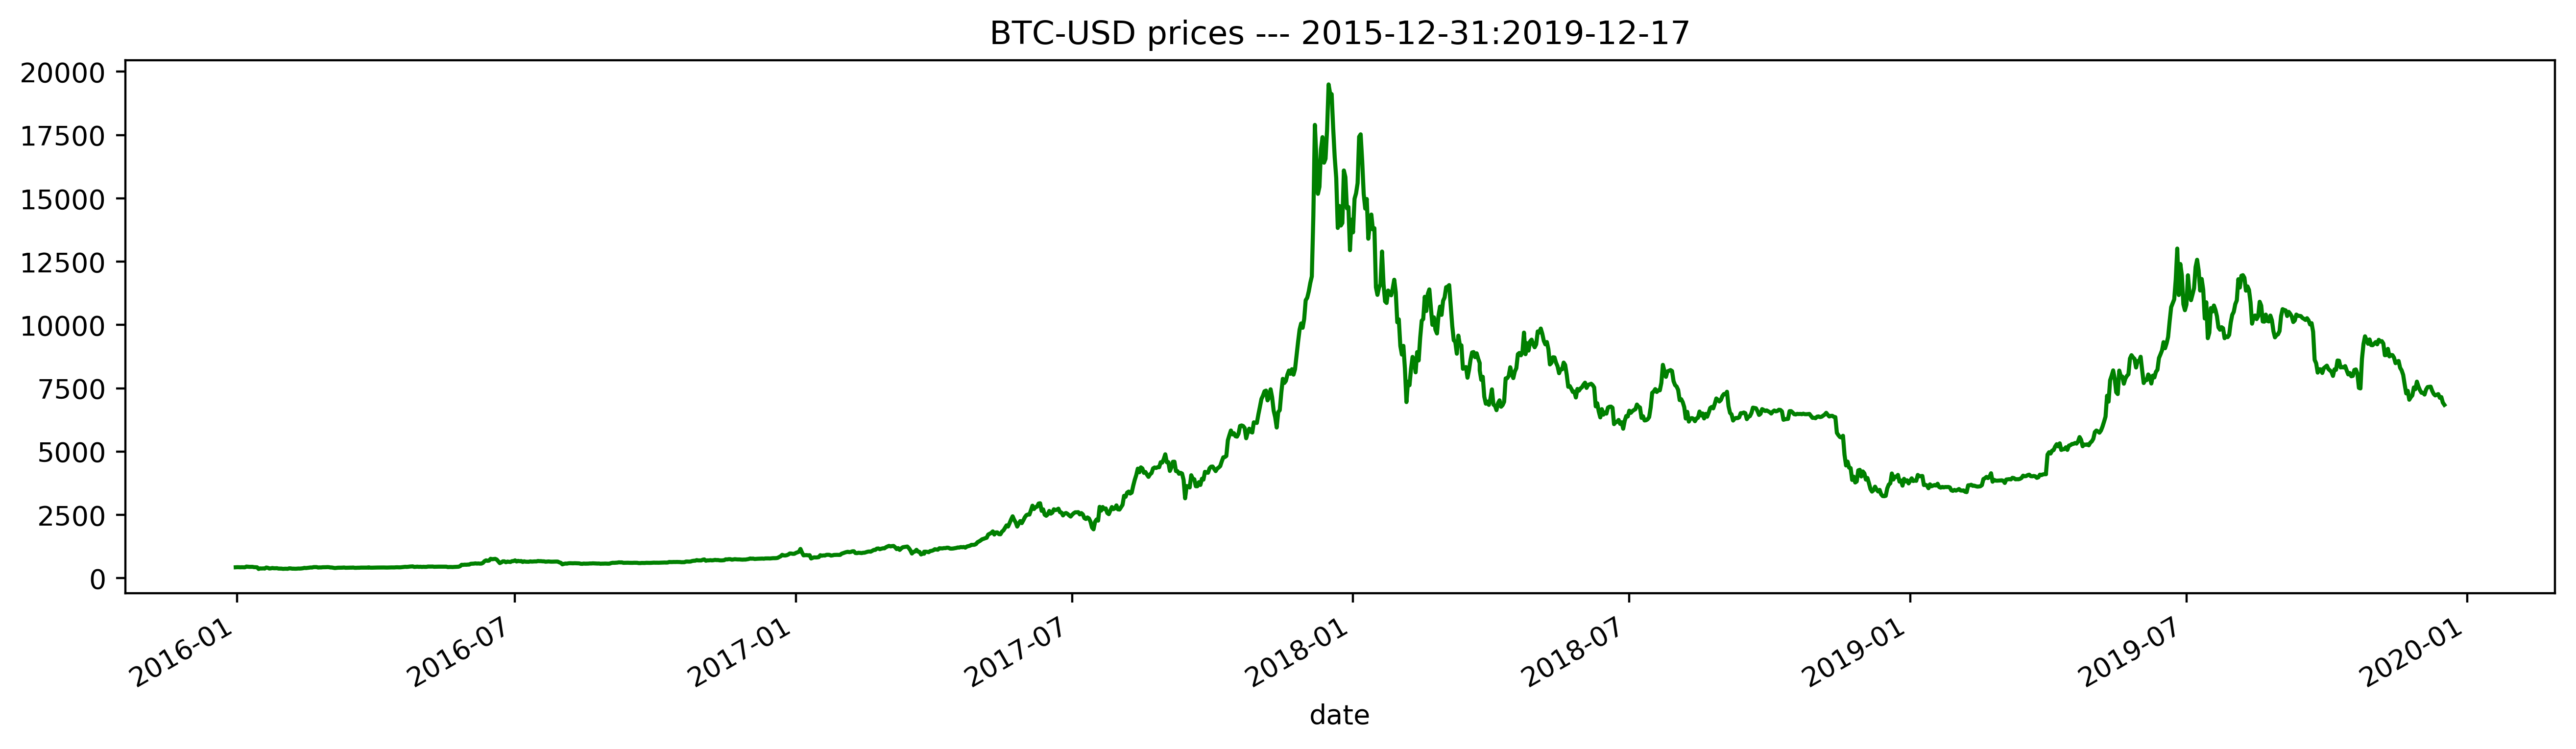

In [89]:
download_csv_data(ticker='BTC-USD', 
                  start_date='2015-12-31', 
                  end_date='2019-12-17', 
                  freq='daily', 
                  path='data/BTC.csv')

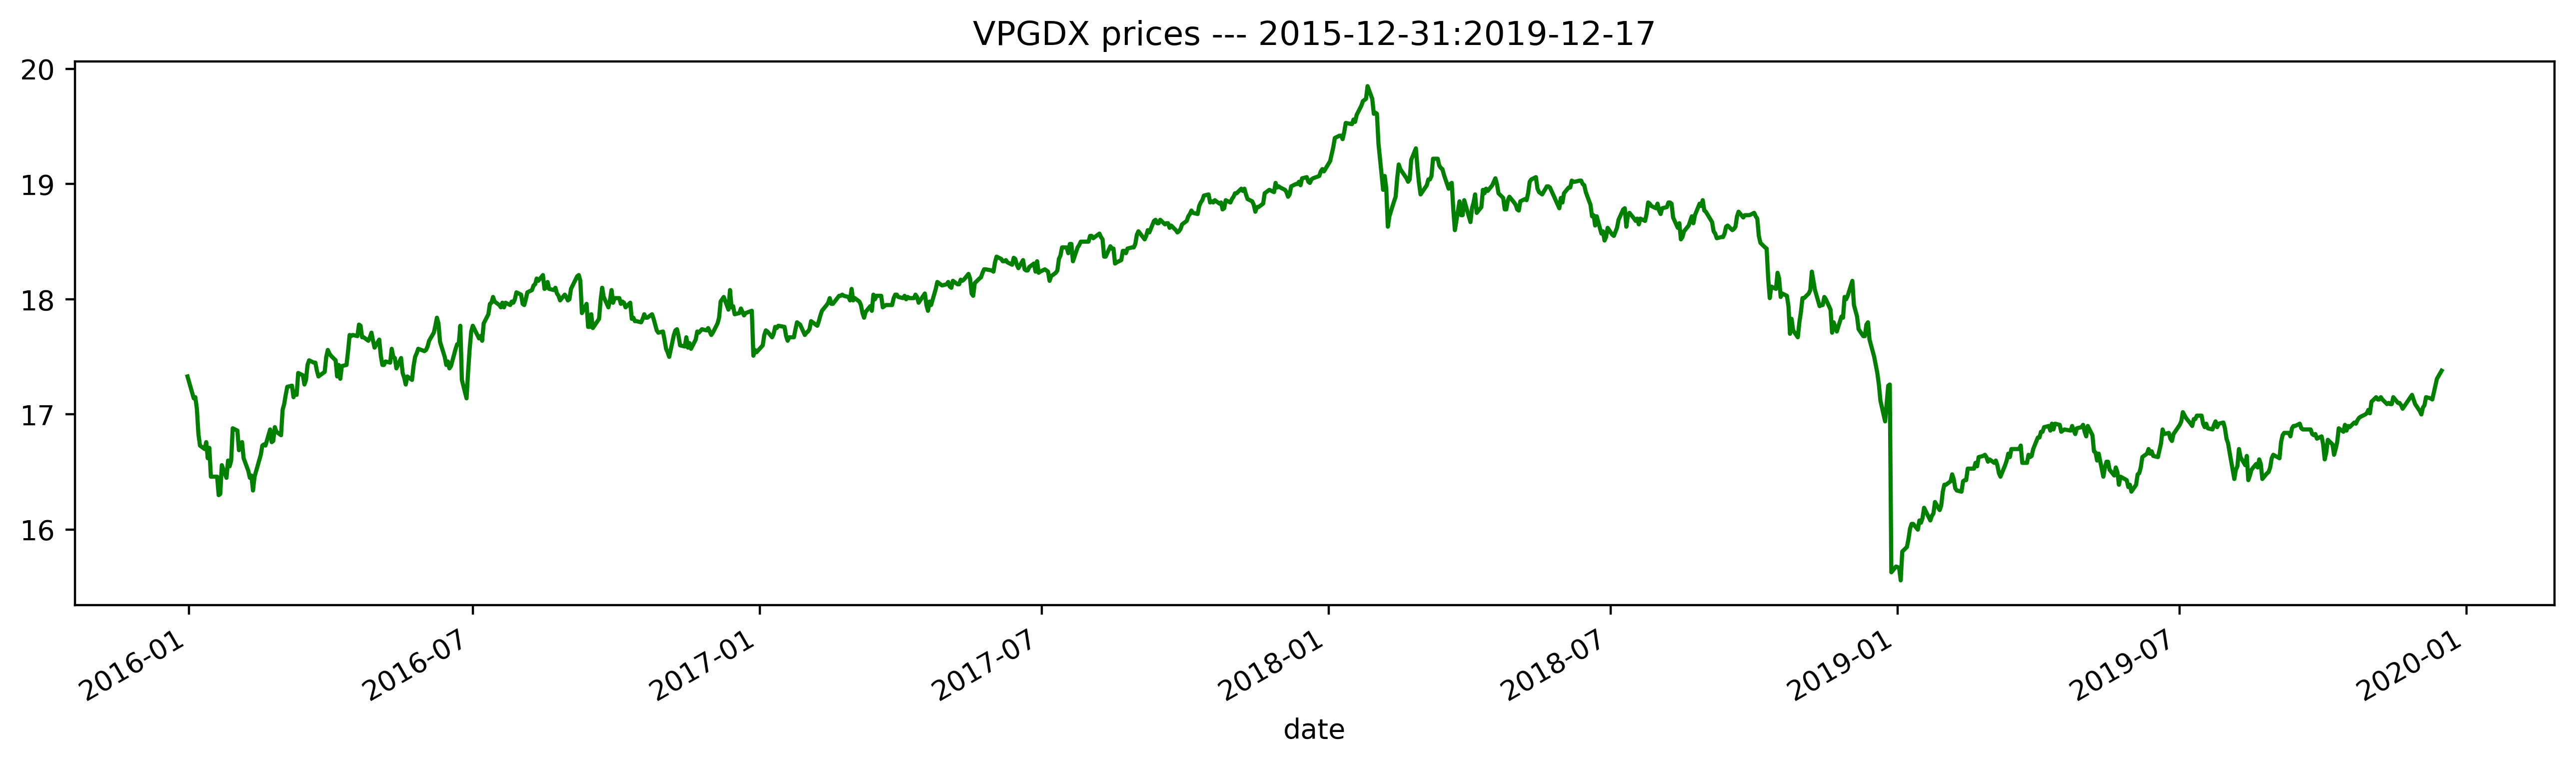

In [90]:
download_csv_data(ticker='VPGDX', 
                  start_date='2015-12-31', 
                  end_date='2019-12-17', 
                  freq='daily', 
                  path='data/VPGDX.csv')

# Симуляция с 5% BTC

In [91]:
# Список финансовых инструментов в портфеле
TIKERS = ['VPGDX', 'BTC']

# Данные которые будут использоваться в дальнейшем
COLUMNS = ['open', 'close', 'adjclose']

In [92]:
data = OrderedDict()

for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    print(data[tiker].tail())

                 open      close   adjclose
date                                       
2019-12-12  17.250000  17.250000  17.250000
2019-12-13  17.309999  17.309999  17.309999
2019-12-14  17.309999  17.309999  17.309999
2019-12-15  17.309999  17.309999  17.309999
2019-12-16  17.379999  17.379999  17.379999
                   open        close     adjclose
date                                             
2019-12-13  7244.662109  7269.684570  7269.684570
2019-12-14  7268.902832  7124.673828  7124.673828
2019-12-15  7124.239746  7152.301758  7152.301758
2019-12-16  7153.663086  6932.480469  6932.480469
2019-12-17  6932.012207  6845.306152  6845.306152


In [93]:
for tiker in TIKERS:
    data[tiker]['close'] = data[tiker]['adjclose']
    data[tiker]['open'] = data[tiker]['adjclose']
    del data[tiker]['adjclose']
    print(data[tiker].tail())
COLUMNS = ['open', 'close']

                 open      close
date                            
2019-12-12  17.250000  17.250000
2019-12-13  17.309999  17.309999
2019-12-14  17.309999  17.309999
2019-12-15  17.309999  17.309999
2019-12-16  17.379999  17.379999
                   open        close
date                                
2019-12-13  7269.684570  7269.684570
2019-12-14  7124.673828  7124.673828
2019-12-15  7152.301758  7152.301758
2019-12-16  6932.480469  6932.480469
2019-12-17  6845.306152  6845.306152


In [94]:
panel = pd.Panel(data)
panel.minor_axis = COLUMNS
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 2 (items) x 1448 (major_axis) x 2 (minor_axis)
Items axis: VPGDX to BTC
Major_axis axis: 2015-12-31 00:00:00+00:00 to 2019-12-17 00:00:00+00:00
Minor_axis axis: open to close


In [95]:
WEIGHTS = [0.94, 0.05]
COMMISSION = 0.001

In [96]:
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))
    
    set_benchmark(symbol('VPGDX'))
    
    context.tikers = TIKERS
    context.assets = [context.symbol(symbol) for symbol in context.tikers]
    
    context.weights = WEIGHTS
    context.n_assets = len(context.assets)
    
    context.window = 1
    
    context.rebalance_period = 20
    context.time = 0

In [97]:
def handle_data(context, data):
    
    # Закупка и ребаллансировка
    if context.time == 0 or (context.time % context.rebalance_period == 0):
        
        
        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])
            
    
    context.time += 1

In [98]:
perf = zipline.run_algorithm(start=datetime(2015, 12, 31, 0, 0, 0, 0, pytz.utc),
                              end=datetime(2019, 12, 16, 0, 0, 0, 0, pytz.utc),
                              initialize=initialize,
                              capital_base=10000000,
                              handle_data=handle_data,
                              data=panel)

In [99]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)

In [100]:
qf.get_performance_summary(returns)

annual_volatility     0.075518
annualized_returns    0.127516
cumulative_returns    0.608506
max_drawdown         -0.143817
sharpe_ratio          1.627386
sortino_ratio         2.383695
dtype: float64

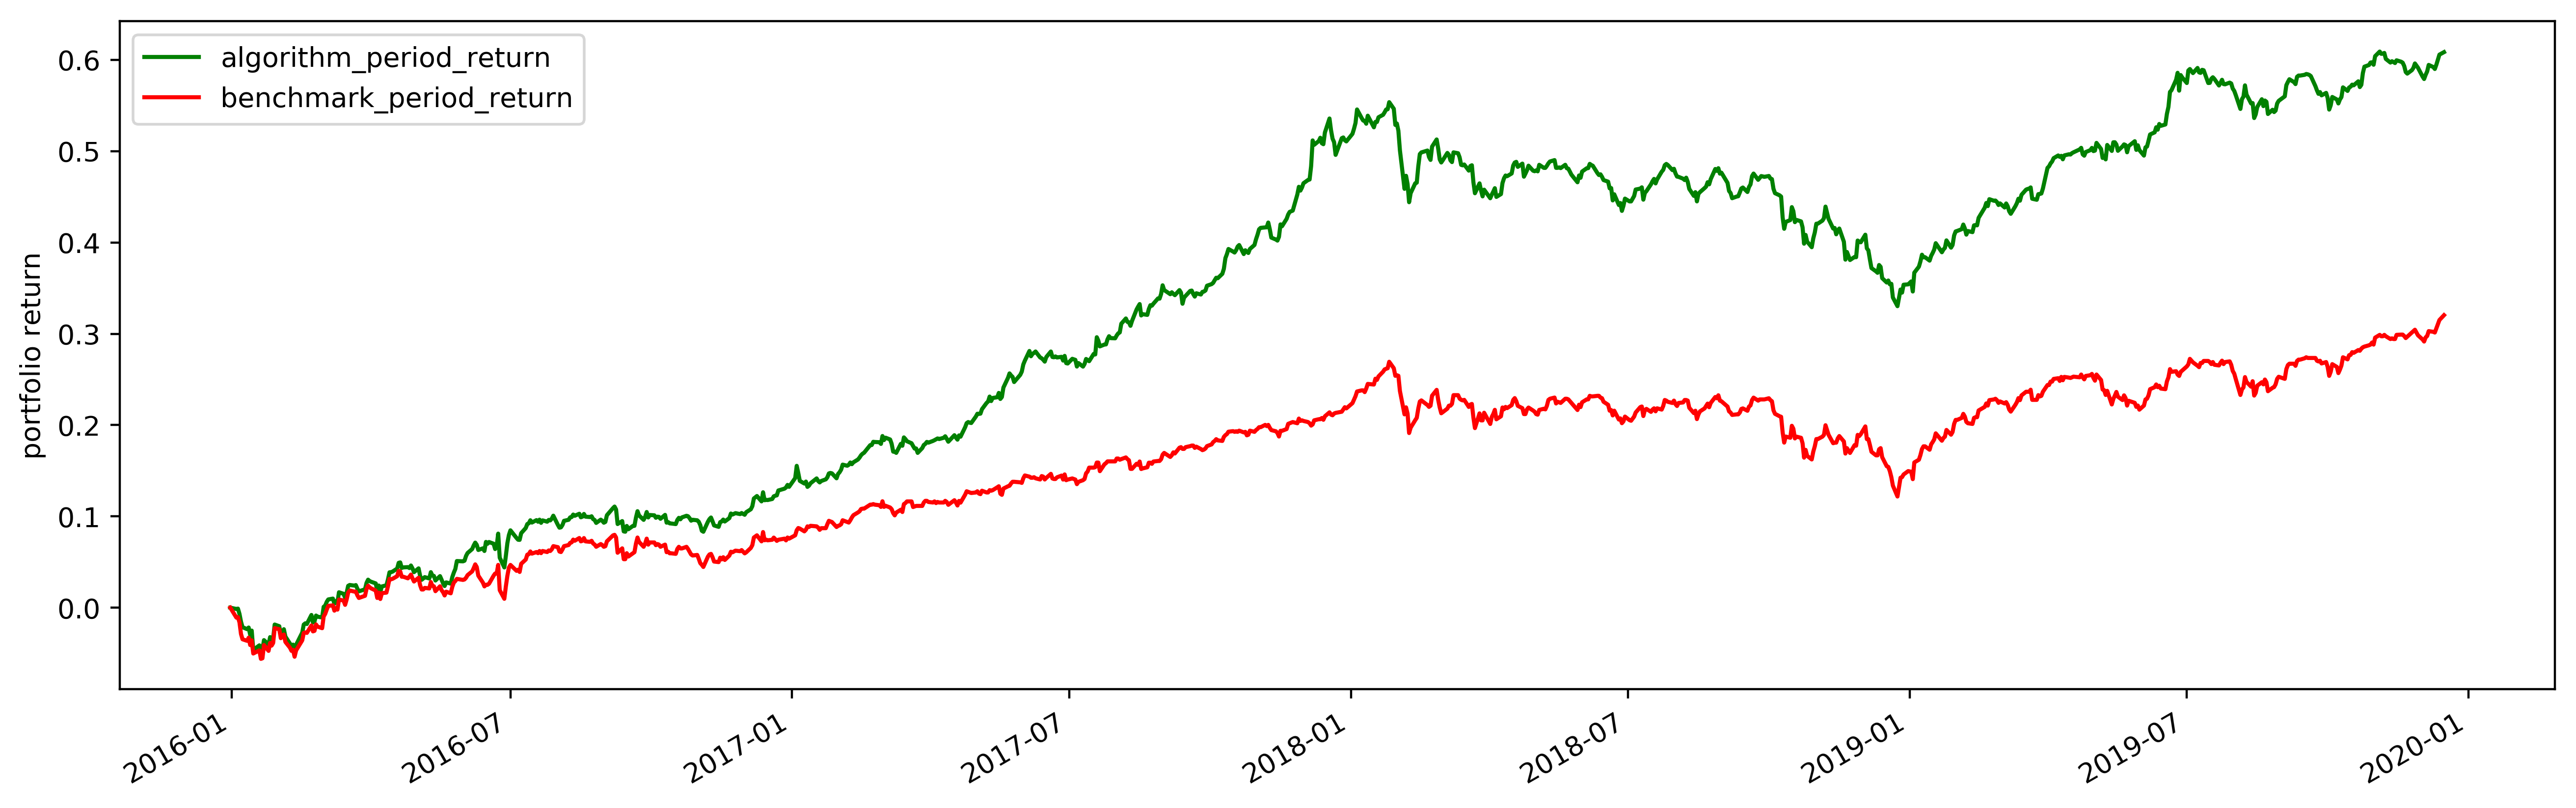

Final portfolio return: 60.85%
Final benchmark return: 32.04%


In [101]:
fig, ax = plt.subplots(figsize=[16, 5])

# portfolio value
perf.algorithm_period_return.plot(color='g')
perf.benchmark_period_return.plot(color='r')

ax.set_ylabel('portfolio return')

plt.legend()
plt.show()

print('Final portfolio return: {}%'.format(np.round(perf.algorithm_period_return[-1] * 100, 2)))
print('Final benchmark return: {}%'.format(np.round(perf.benchmark_period_return[-1] * 100, 2)))

In [102]:
(perf.portfolio_value/100000).tail()

2019-12-10 00:00:00+00:00    159.003999
2019-12-11 00:00:00+00:00    159.469444
2019-12-12 00:00:00+00:00    160.021273
2019-12-13 00:00:00+00:00    160.573945
2019-12-16 00:00:00+00:00    160.850552
Name: portfolio_value, dtype: float64

In [103]:
bitcoin5 = perf.algorithm_period_return

In [104]:
bitcoinPortfolio5 = 1000 * (1 + bitcoin5)

bitcoinPortfolio5 = bitcoinPortfolio5.rename('BTC 5% Target') 

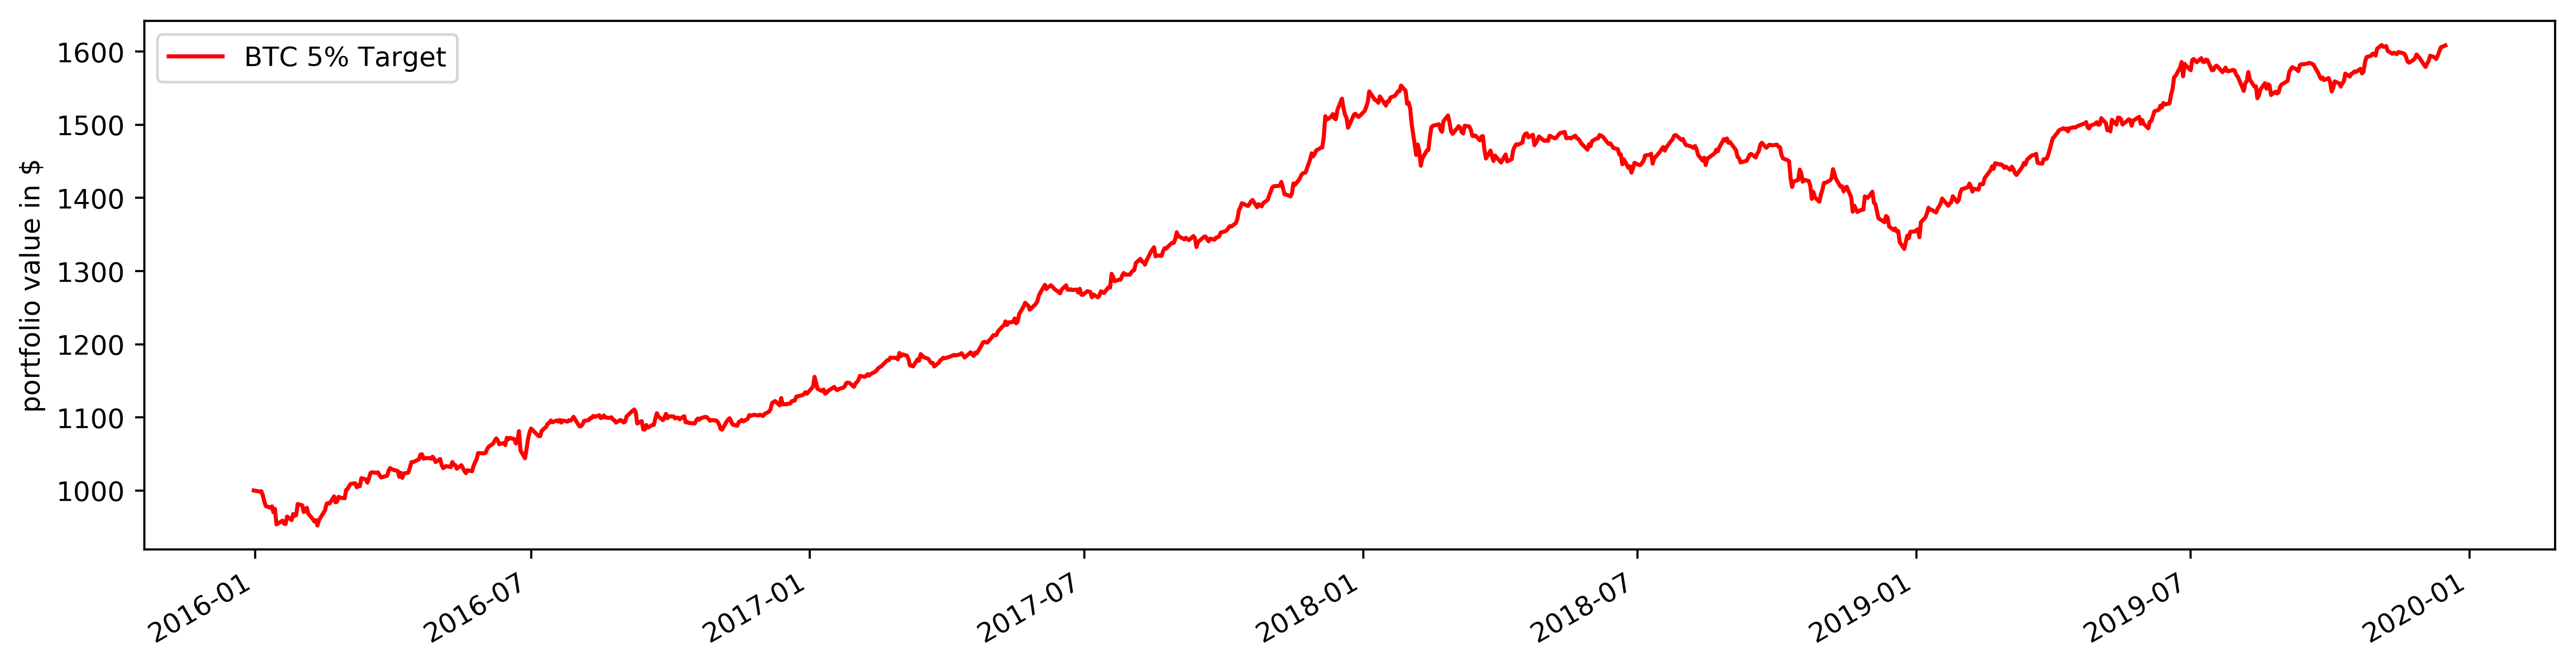

In [105]:
fig, ax = plt.subplots(figsize=[16, 4])

# portfolio value
bitcoinPortfolio5.plot(color='r')
#portfolio1.plot(color='gold')
#vanguard.plot(color='gray')

ax.set_ylabel('portfolio value in $')

plt.legend()
plt.show()

In [106]:
#Поправляем индексацию

new_index = pd.Series(pd.to_datetime(positions.index).date).map(lambda x: x.strftime('%Y-%m-%d'))
weights_df = pd.DataFrame.from_records(positions, index=new_index)
weights_df.head()

Equity(0 [VPGDX])  Equity(1 [BTC])           cash
2016-01-04       9.296930e+06    502818.654968  185546.717369
2016-01-05       9.302354e+06    501505.550079  185546.717369
2016-01-06       9.248115e+06    498190.917755  185546.717369
2016-01-07       9.128784e+06    531793.732819  185546.717369
2016-01-08       9.074545e+06    526200.042755  185546.717369

In [107]:
# Поправляем названия столбцов

weights_df.columns = ['VPGDX', 'BTC', 'Cash']

In [108]:
# Нормирование весов в файле

norm_weights_df = weights_df.copy()

norm_weights_df['BTC'] = weights_df['BTC']/(weights_df['BTC'] + weights_df['VPGDX'] + weights_df['Cash'])    
norm_weights_df['VPGDX'] = weights_df['VPGDX']/(weights_df['VPGDX'] + weights_df['BTC'] + weights_df['Cash'])
norm_weights_df['Cash'] = weights_df['Cash']/(weights_df['VPGDX'] + weights_df['BTC'] + weights_df['Cash'])

In [109]:
# convert date objects from pandas format to python datetime
norm_weights_df.index = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in norm_weights_df.index]

In [110]:
norm_weights_df.tail()

VPGDX       BTC      Cash
2019-12-10  0.944687  0.045773  0.009540
2019-12-11  0.945229  0.045259  0.009512
2019-12-12  0.945257  0.045264  0.009479
2019-12-13  0.945280  0.045273  0.009446
2019-12-16  0.947471  0.043099  0.009430

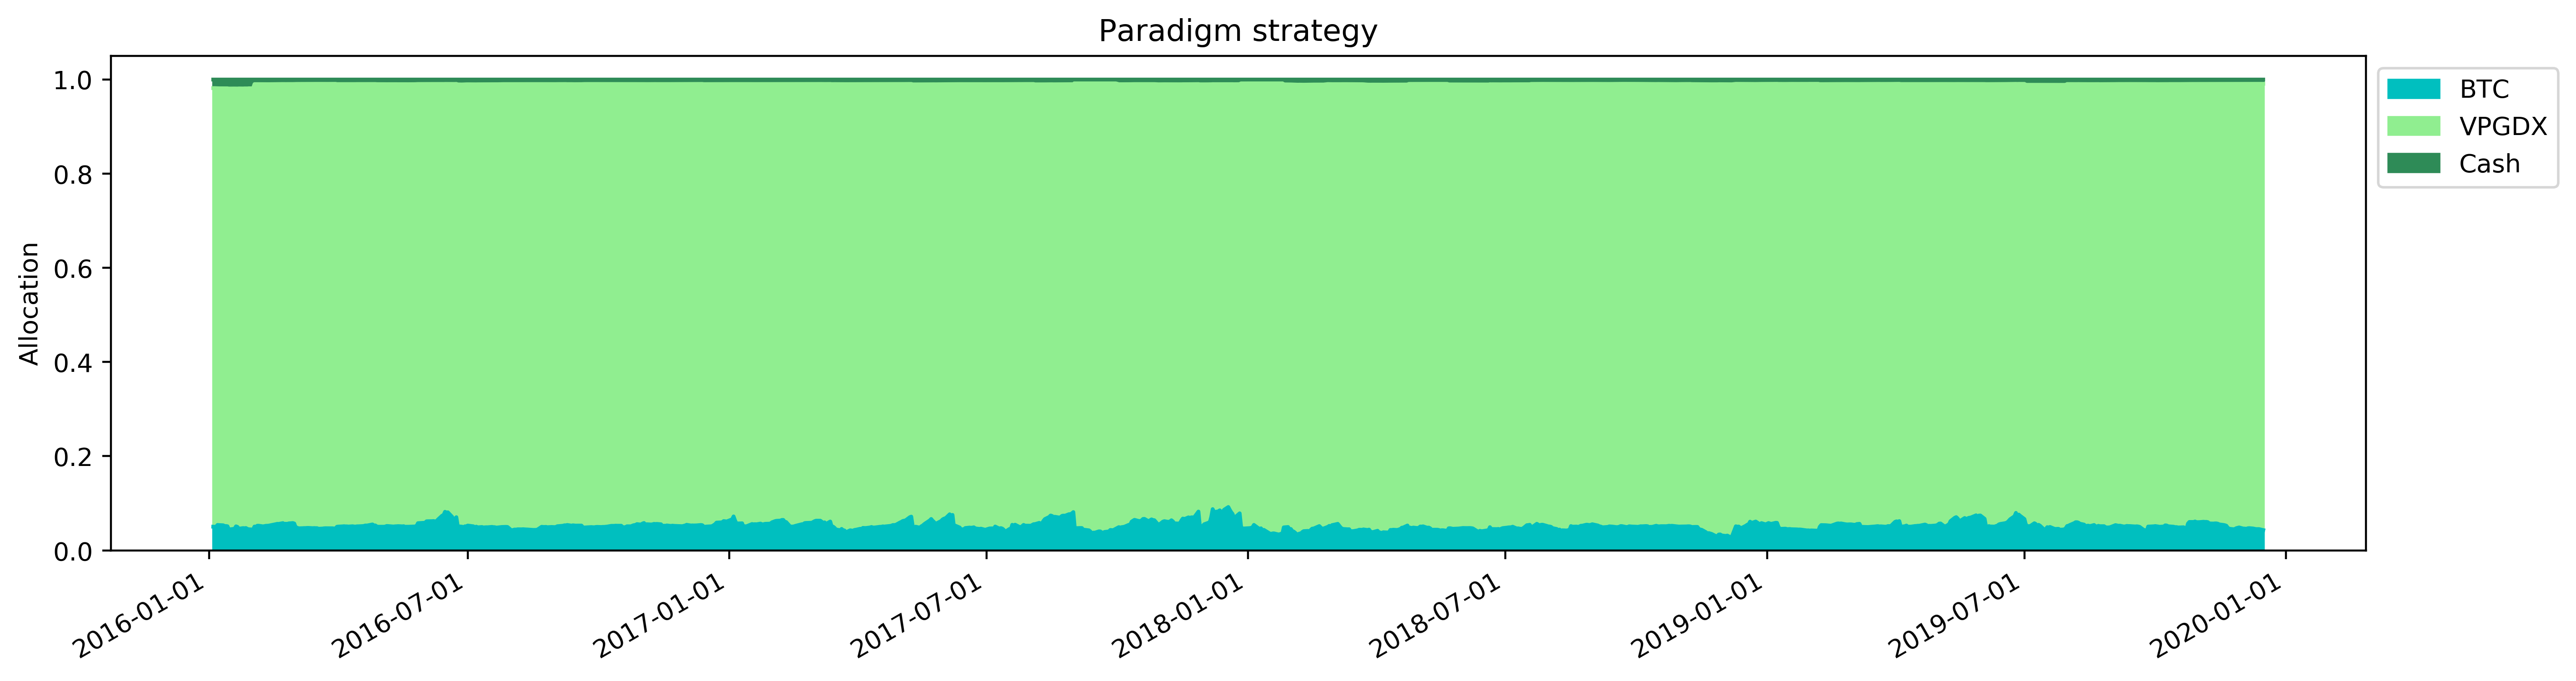

In [111]:
norm_weights_df = norm_weights_df[['BTC', 'VPGDX', 'Cash']]
# plot the results
col = ['c', 'lightgreen', 'seagreen']
ax = norm_weights_df.plot(kind='area', stacked=True, color = col) # stacked=True показывает веса в одном столбце

# set monthly locator

##### Градуировка https://matplotlib.org/3.1.0/gallery/ticks_and_spines/tick-locators.html
#ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# set font and rotation for date tick labels
plt.gcf().autofmt_xdate()

ax.tick_params(axis = 'both', direction = 'out')
ax.set(title = 'Paradigm strategy', ylabel='Allocation')
ax.legend(bbox_to_anchor=(1,1))
plt.show()

# Симуляция с 1% Bitcoin

In [112]:
# Список финансовых инструментов в портфеле
TIKERS = ['VPGDX', 'BTC']

# Данные которые будут использоваться в дальнейшем
COLUMNS = ['open', 'close', 'adjclose']

In [113]:
data = OrderedDict()

for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    print(data[tiker].head())

                 open      close   adjclose
date                                       
2015-12-31  17.330000  17.330000  13.163204
2016-01-01  17.330000  17.330000  13.163204
2016-01-02  17.330000  17.330000  13.163204
2016-01-03  17.330000  17.330000  13.163204
2016-01-04  17.139999  17.139999  13.018887
                  open       close    adjclose
date                                          
2015-12-31  425.875000  430.566986  430.566986
2016-01-01  430.721008  434.334015  434.334015
2016-01-02  434.622009  433.437988  433.437988
2016-01-03  433.578003  430.010986  430.010986
2016-01-04  430.061005  433.091003  433.091003


In [114]:
for tiker in TIKERS:
    data[tiker]['close'] = data[tiker]['adjclose']
    data[tiker]['open'] = data[tiker]['adjclose']
    del data[tiker]['adjclose']
    print(data[tiker].tail())
COLUMNS = ['open', 'close']

                 open      close
date                            
2019-12-12  17.250000  17.250000
2019-12-13  17.309999  17.309999
2019-12-14  17.309999  17.309999
2019-12-15  17.309999  17.309999
2019-12-16  17.379999  17.379999
                   open        close
date                                
2019-12-13  7269.684570  7269.684570
2019-12-14  7124.673828  7124.673828
2019-12-15  7152.301758  7152.301758
2019-12-16  6932.480469  6932.480469
2019-12-17  6845.306152  6845.306152


In [115]:
panel = pd.Panel(data)
panel.minor_axis = COLUMNS
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 2 (items) x 1448 (major_axis) x 2 (minor_axis)
Items axis: VPGDX to BTC
Major_axis axis: 2015-12-31 00:00:00+00:00 to 2019-12-17 00:00:00+00:00
Minor_axis axis: open to close


In [116]:
WEIGHTS = [0.98, 0.01]
COMMISSION = 0.001

In [117]:
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))
    
    set_benchmark(symbol('VPGDX'))
    
    context.tikers = TIKERS
    context.assets = [context.symbol(symbol) for symbol in context.tikers]
    
    context.weights = WEIGHTS
    context.n_assets = len(context.assets)
    
    context.window = 1
    
    context.rebalance_period = 20
    context.time = 0

In [118]:
def handle_data(context, data):
    
    # Закупка и ребаллансировка
    if context.time == 0 or (context.time % context.rebalance_period == 0):
        
        
        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])
            
    
    context.time += 1

In [119]:
perf = zipline.run_algorithm(start=datetime(2015, 12, 31, 0, 0, 0, 0, pytz.utc),
                              end=datetime(2019, 12, 16, 0, 0, 0, 0, pytz.utc),
                              initialize=initialize,
                              capital_base=10000000,
                              handle_data=handle_data,
                              data=panel)

In [120]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)

In [121]:
qf.get_performance_summary(returns)

annual_volatility     0.066882
annualized_returns    0.085317
cumulative_returns    0.382979
max_drawdown         -0.120760
sharpe_ratio          1.257783
sortino_ratio         1.774499
dtype: float64

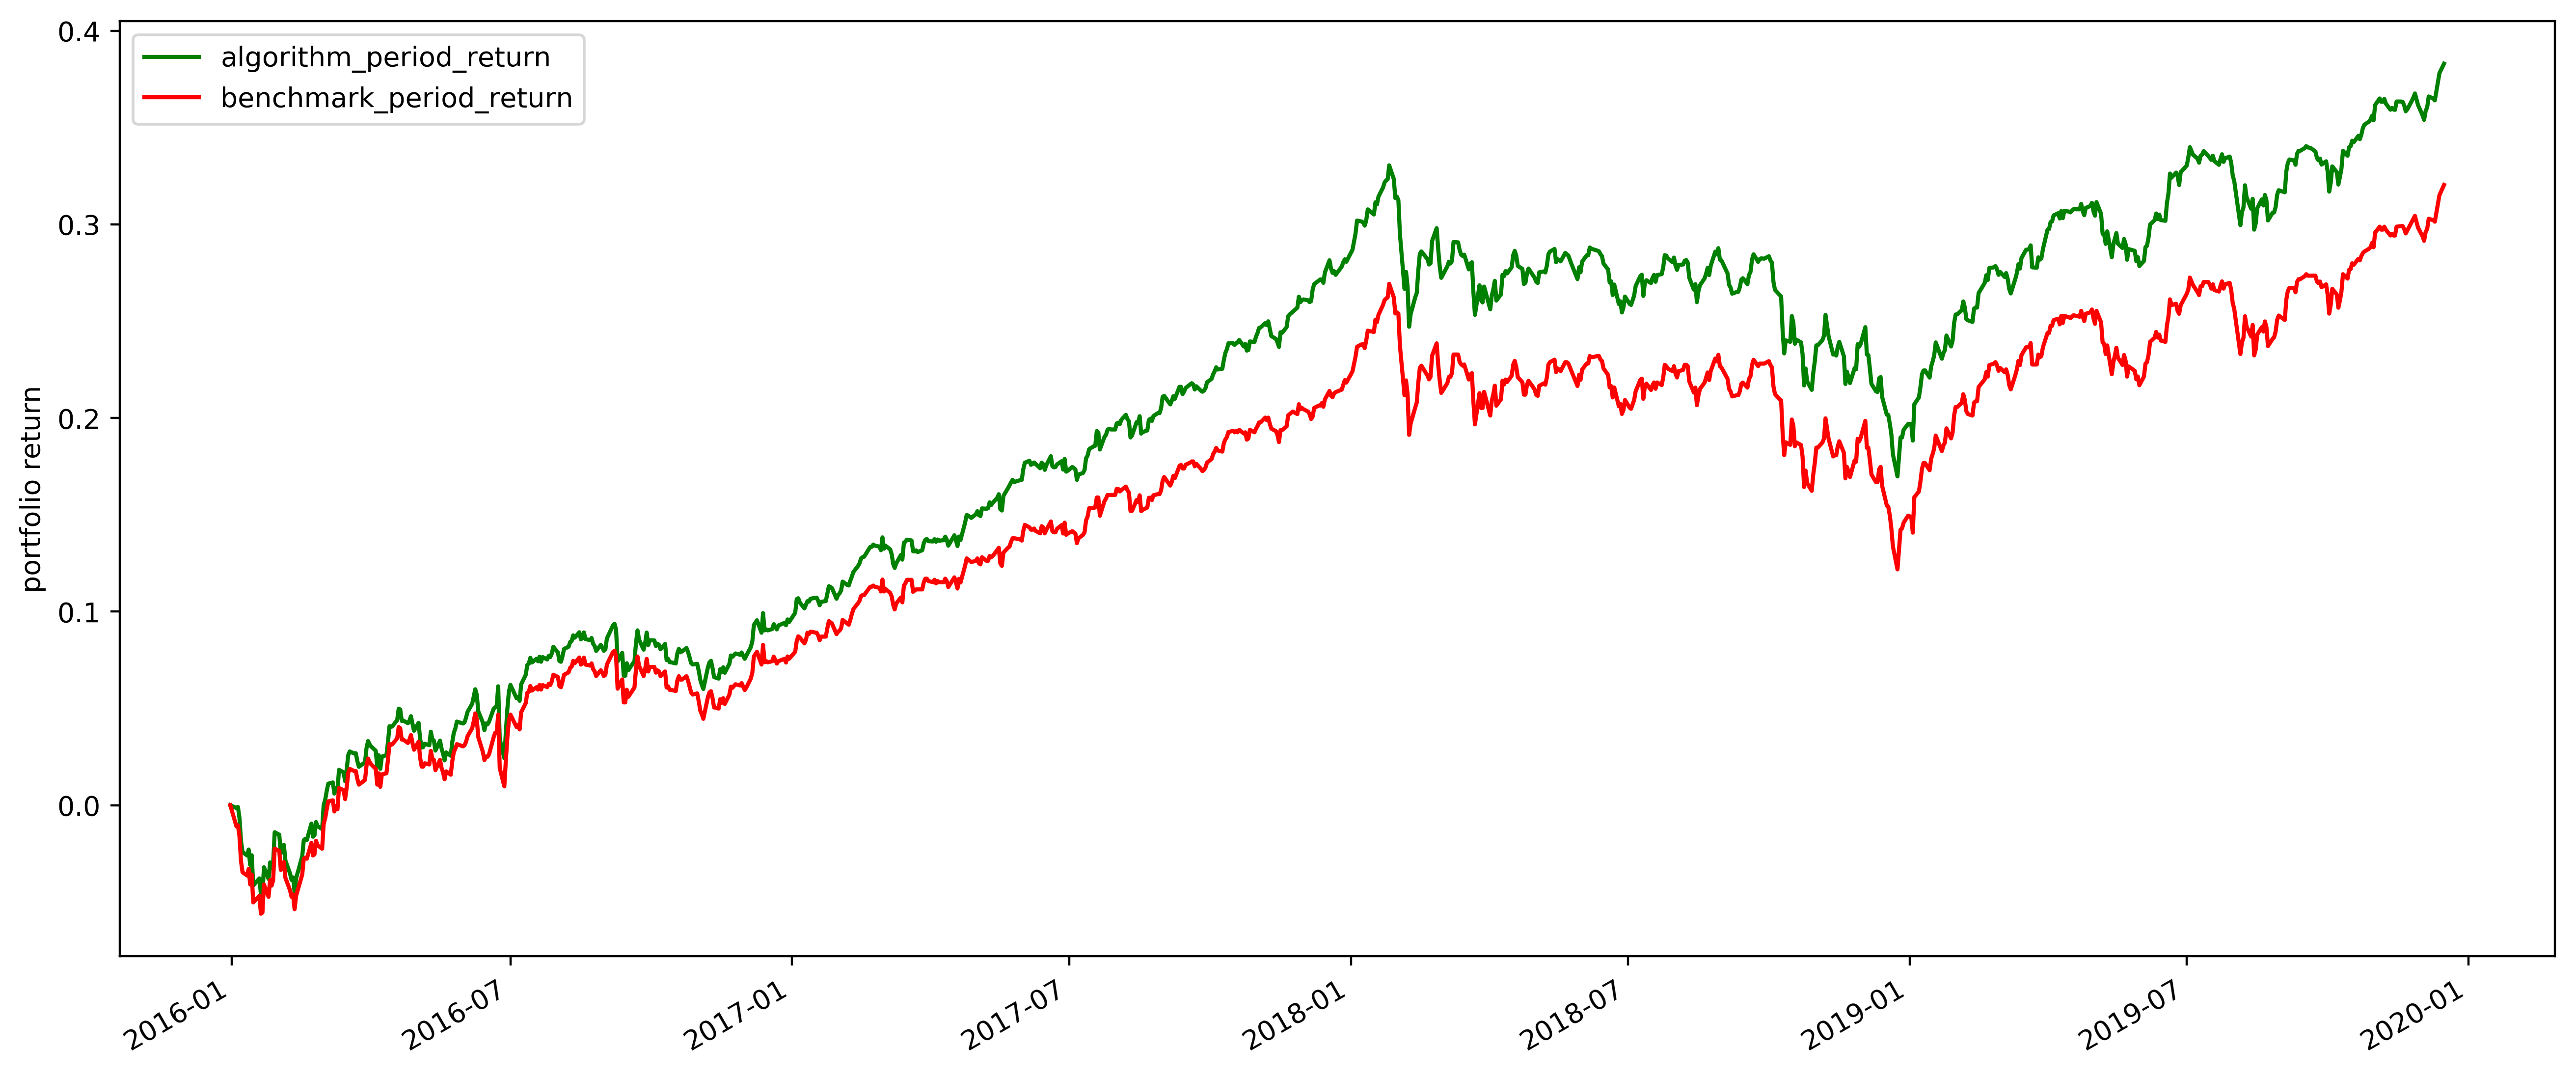

Final portfolio return: 38.3%
Final benchmark return: 32.04%


In [122]:
fig, ax = plt.subplots(figsize=[16, 7])

# portfolio value
perf.algorithm_period_return.plot(color='g')
perf.benchmark_period_return.plot(color='r')

ax.set_ylabel('portfolio return')

plt.legend()
plt.show()

print('Final portfolio return: {}%'.format(np.round(perf.algorithm_period_return[-1] * 100, 2)))
print('Final benchmark return: {}%'.format(np.round(perf.benchmark_period_return[-1] * 100, 2)))

In [123]:
bitcoin1 = perf.algorithm_period_return

In [124]:
vanguard = perf.benchmark_period_return

In [125]:
bitcoinPortfolio1 = 1000 * (1 + bitcoin1)
benchmark = 1000 * (1 + vanguard)

bitcoinPortfolio1 = bitcoinPortfolio1.rename('BTC 1% Target')
benchmark = benchmark.rename('No BTC') 

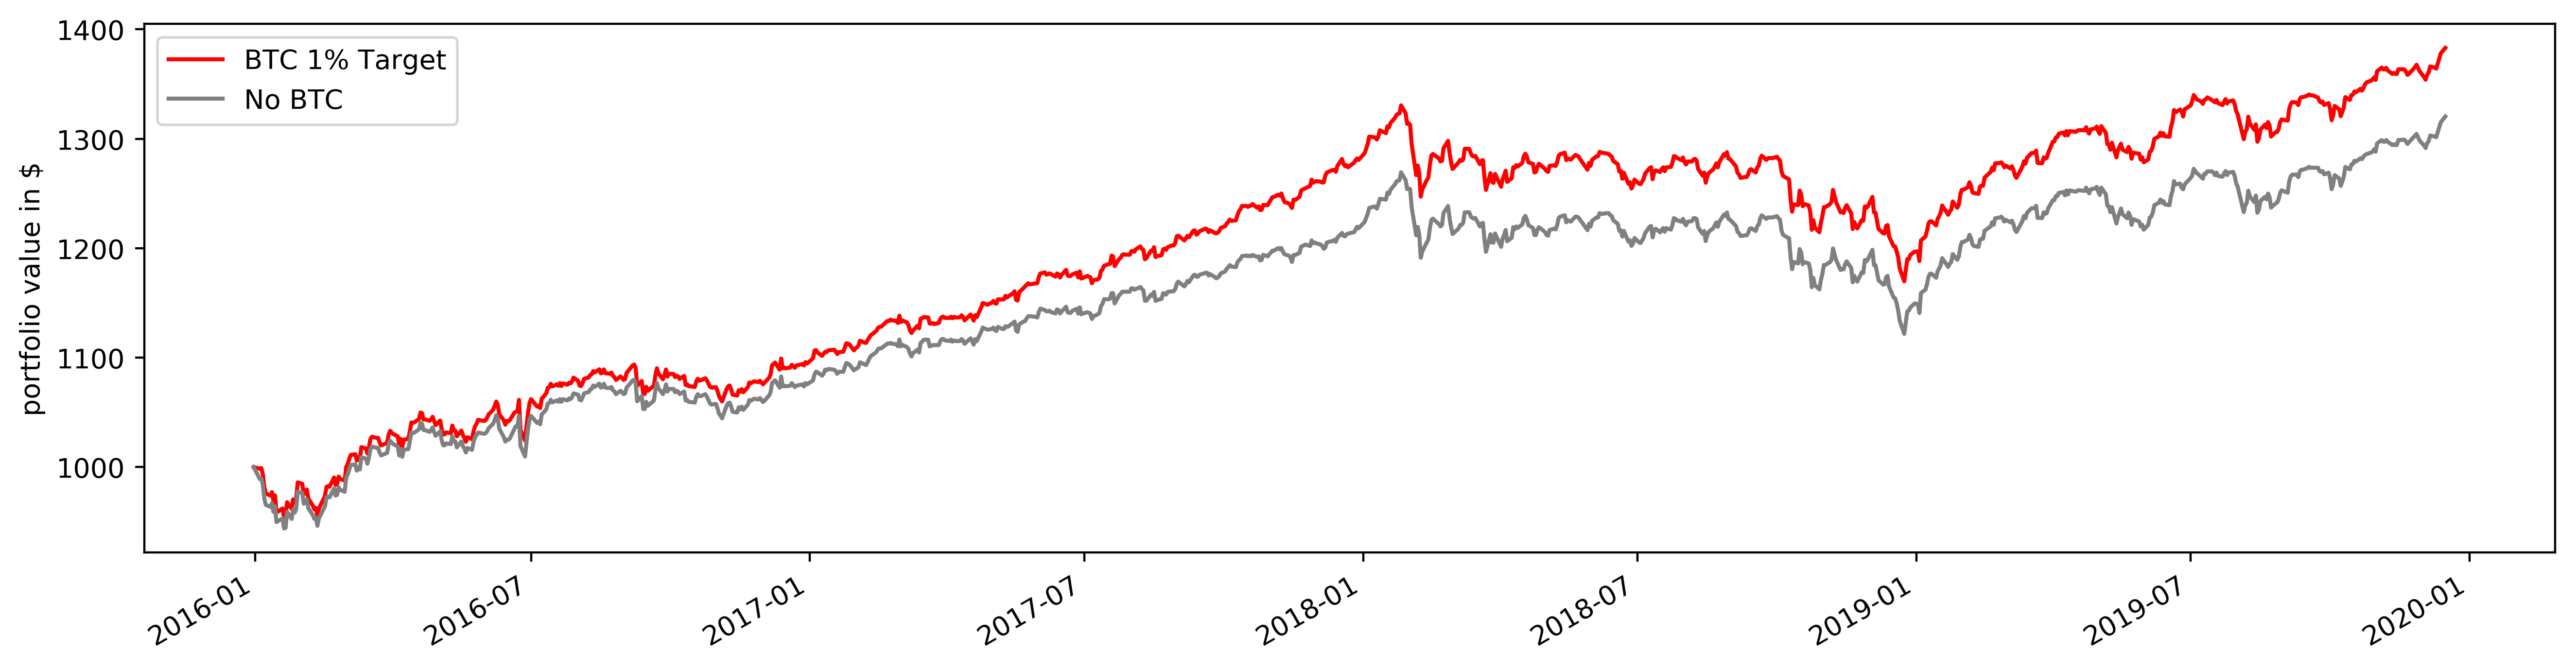

In [126]:
fig, ax = plt.subplots(figsize=[16, 4])

# portfolio value
bitcoinPortfolio1.plot(color='r')
benchmark.plot(color='gray')

ax.set_ylabel('portfolio value in $')

plt.legend()
plt.show()

In [127]:
#Поправляем индексацию

new_index = pd.Series(pd.to_datetime(positions.index).date).map(lambda x: x.strftime('%Y-%m-%d'))
weights_df = pd.DataFrame.from_records(positions, index=new_index)
weights_df.tail()

Equity(0 [VPGDX])  Equity(1 [BTC])           cash
2019-12-10       1.338082e+07    123728.033691  135831.893999
2019-12-11       1.342769e+07    122696.263184  135831.893999
2019-12-12       1.347456e+07    123133.282715  135831.893999
2019-12-13       1.352143e+07    123584.637695  135831.893999
2019-12-16       1.357611e+07    117852.167969  135831.893999

In [128]:
# Поправляем названия столбцов

weights_df.columns = ['VPGDX', 'BTC', 'Cash']

In [129]:
# Нормирование весов в файле

norm_weights_df = weights_df.copy()

norm_weights_df['BTC'] = weights_df['BTC']/(weights_df['BTC'] + weights_df['VPGDX'] + weights_df['Cash'])    
norm_weights_df['VPGDX'] = weights_df['VPGDX']/(weights_df['VPGDX'] + weights_df['BTC'] + weights_df['Cash'])
norm_weights_df['Cash'] = weights_df['Cash']/(weights_df['VPGDX'] + weights_df['BTC'] + weights_df['Cash'])

In [130]:
# convert date objects from pandas format to python datetime
norm_weights_df.index = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in norm_weights_df.index]

In [131]:
norm_weights_df.tail()

VPGDX       BTC      Cash
2019-12-10  0.980971  0.009071  0.009958
2019-12-11  0.981110  0.008965  0.009925
2019-12-12  0.981144  0.008966  0.009891
2019-12-13  0.981176  0.008968  0.009857
2019-12-16  0.981657  0.008522  0.009822

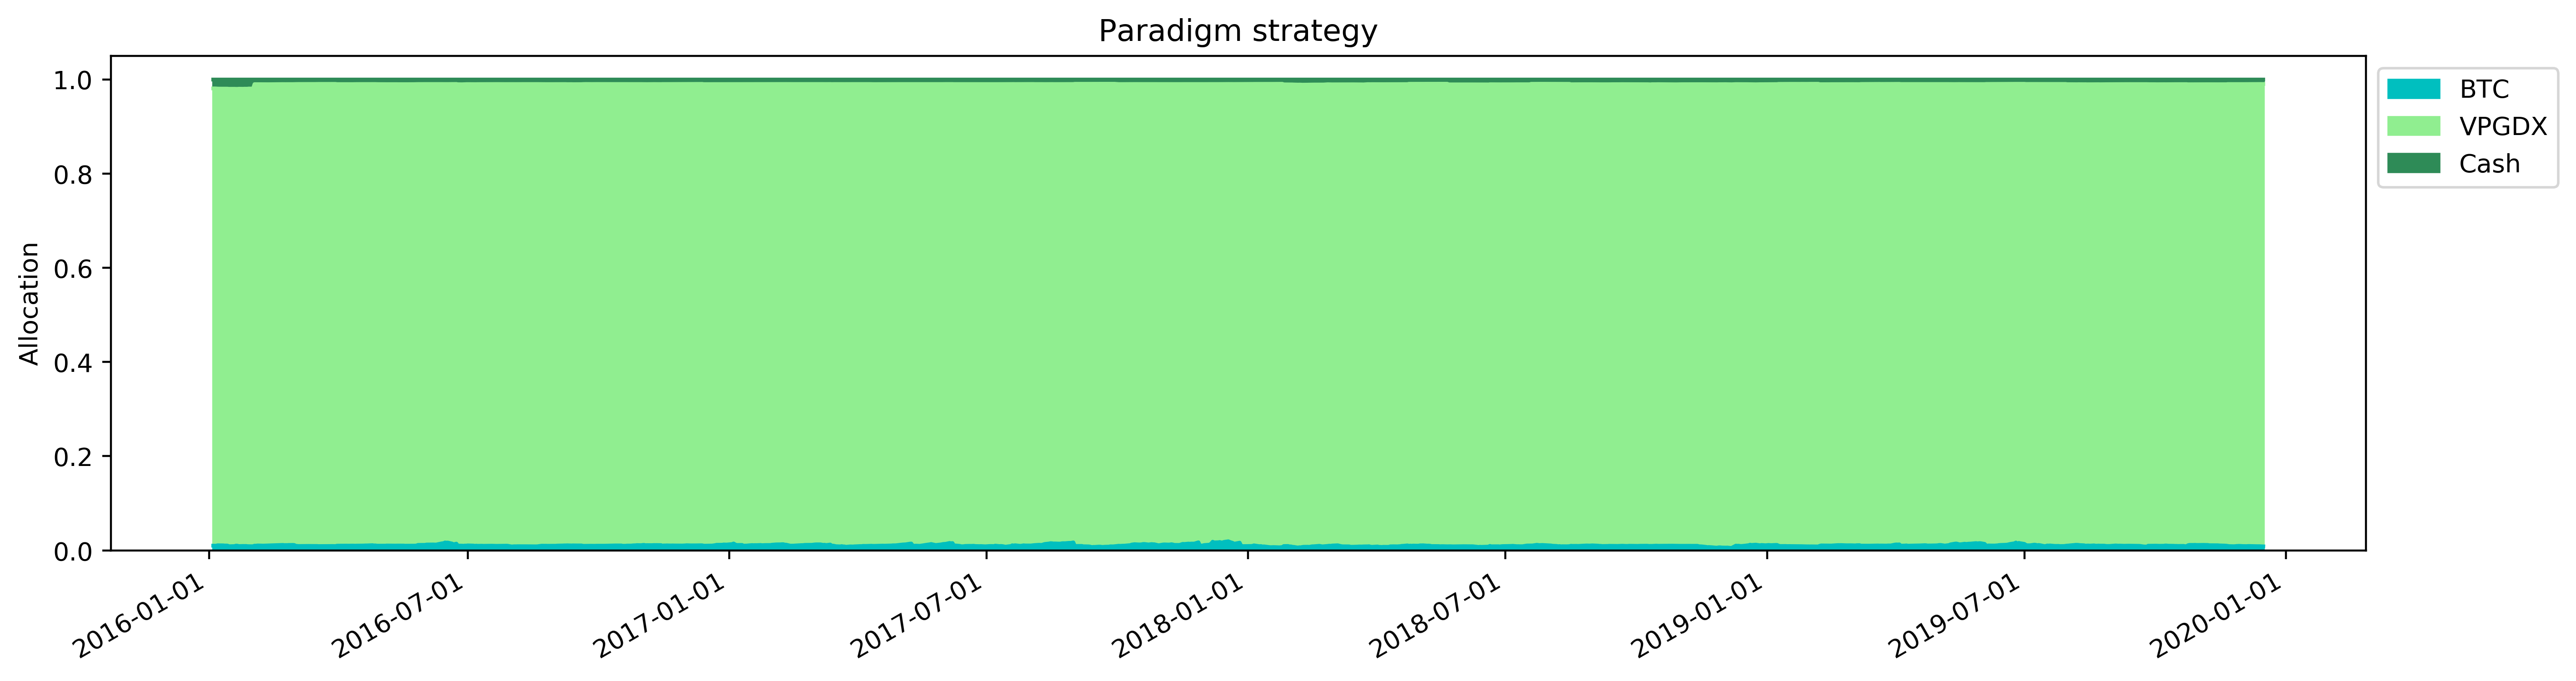

In [132]:
norm_weights_df = norm_weights_df[['BTC', 'VPGDX', 'Cash']]
# plot the results
col = ['c', 'lightgreen', 'seagreen']
ax = norm_weights_df.plot(kind='area', stacked=True, color = col) # stacked=True показывает веса в одном столбце

# set monthly locator

##### Градуировка https://matplotlib.org/3.1.0/gallery/ticks_and_spines/tick-locators.html
#ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# set font and rotation for date tick labels
plt.gcf().autofmt_xdate()

ax.tick_params(axis = 'both', direction = 'out')
ax.set(title = 'Paradigm strategy', ylabel='Allocation')
ax.legend(bbox_to_anchor=(1,1))
plt.show()

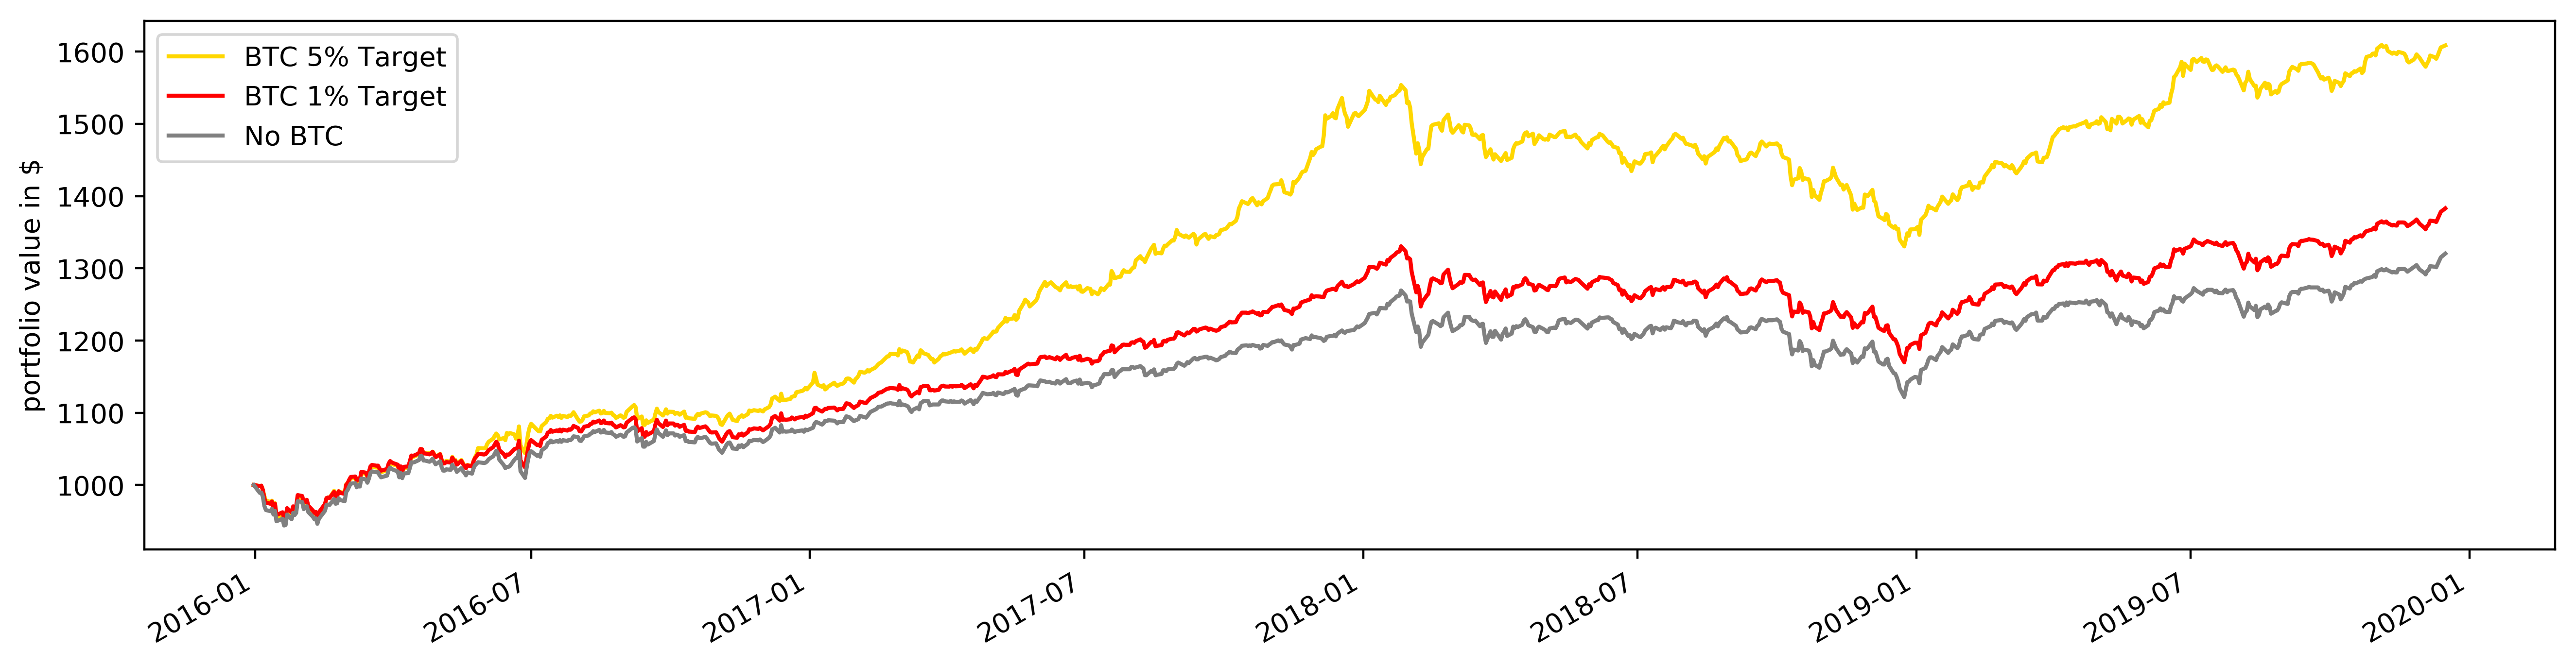

In [133]:
fig, ax = plt.subplots(figsize=[16, 4])

# portfolio value
bitcoinPortfolio5.plot(color='gold')
bitcoinPortfolio1.plot(color='r')
benchmark.plot(color='gray')

ax.set_ylabel('portfolio value in $')

plt.legend()
plt.show()

In [134]:
fig.savefig('vanguard.png', transparent=False, dpi=300, bbox_inches="tight")

# Просадки

In [135]:
window = 365

In [136]:
# Calculate the max drawdown in the past window days for each day in the series.
# Use min_periods=1 if you want to let the first 365 days data have an expanding window
Roll_Max1 = pd.rolling_max(bitcoinPortfolio1, window, min_periods=1)
Roll_Max2 = pd.rolling_max(bitcoinPortfolio5, window, min_periods=1)
Roll_Max3 = pd.rolling_max(benchmark, window, min_periods=1)
Daily_Drawdown1 = bitcoinPortfolio1/Roll_Max1 - 1.0
Daily_Drawdown2 = bitcoinPortfolio5/Roll_Max2 - 1.0
Daily_Drawdown3 = benchmark/Roll_Max3 - 1.0

In [137]:
# Next we calculate the minimum (negative) daily drawdown in that window.
# Again, use min_periods=1 if you want to allow the expanding window
Max_Daily_Drawdown1 = pd.rolling_min(Daily_Drawdown1, window, min_periods=1)
Max_Daily_Drawdown2 = pd.rolling_min(Daily_Drawdown2, window, min_periods=1)
Max_Daily_Drawdown3 = pd.rolling_min(Daily_Drawdown3, window, min_periods=1)

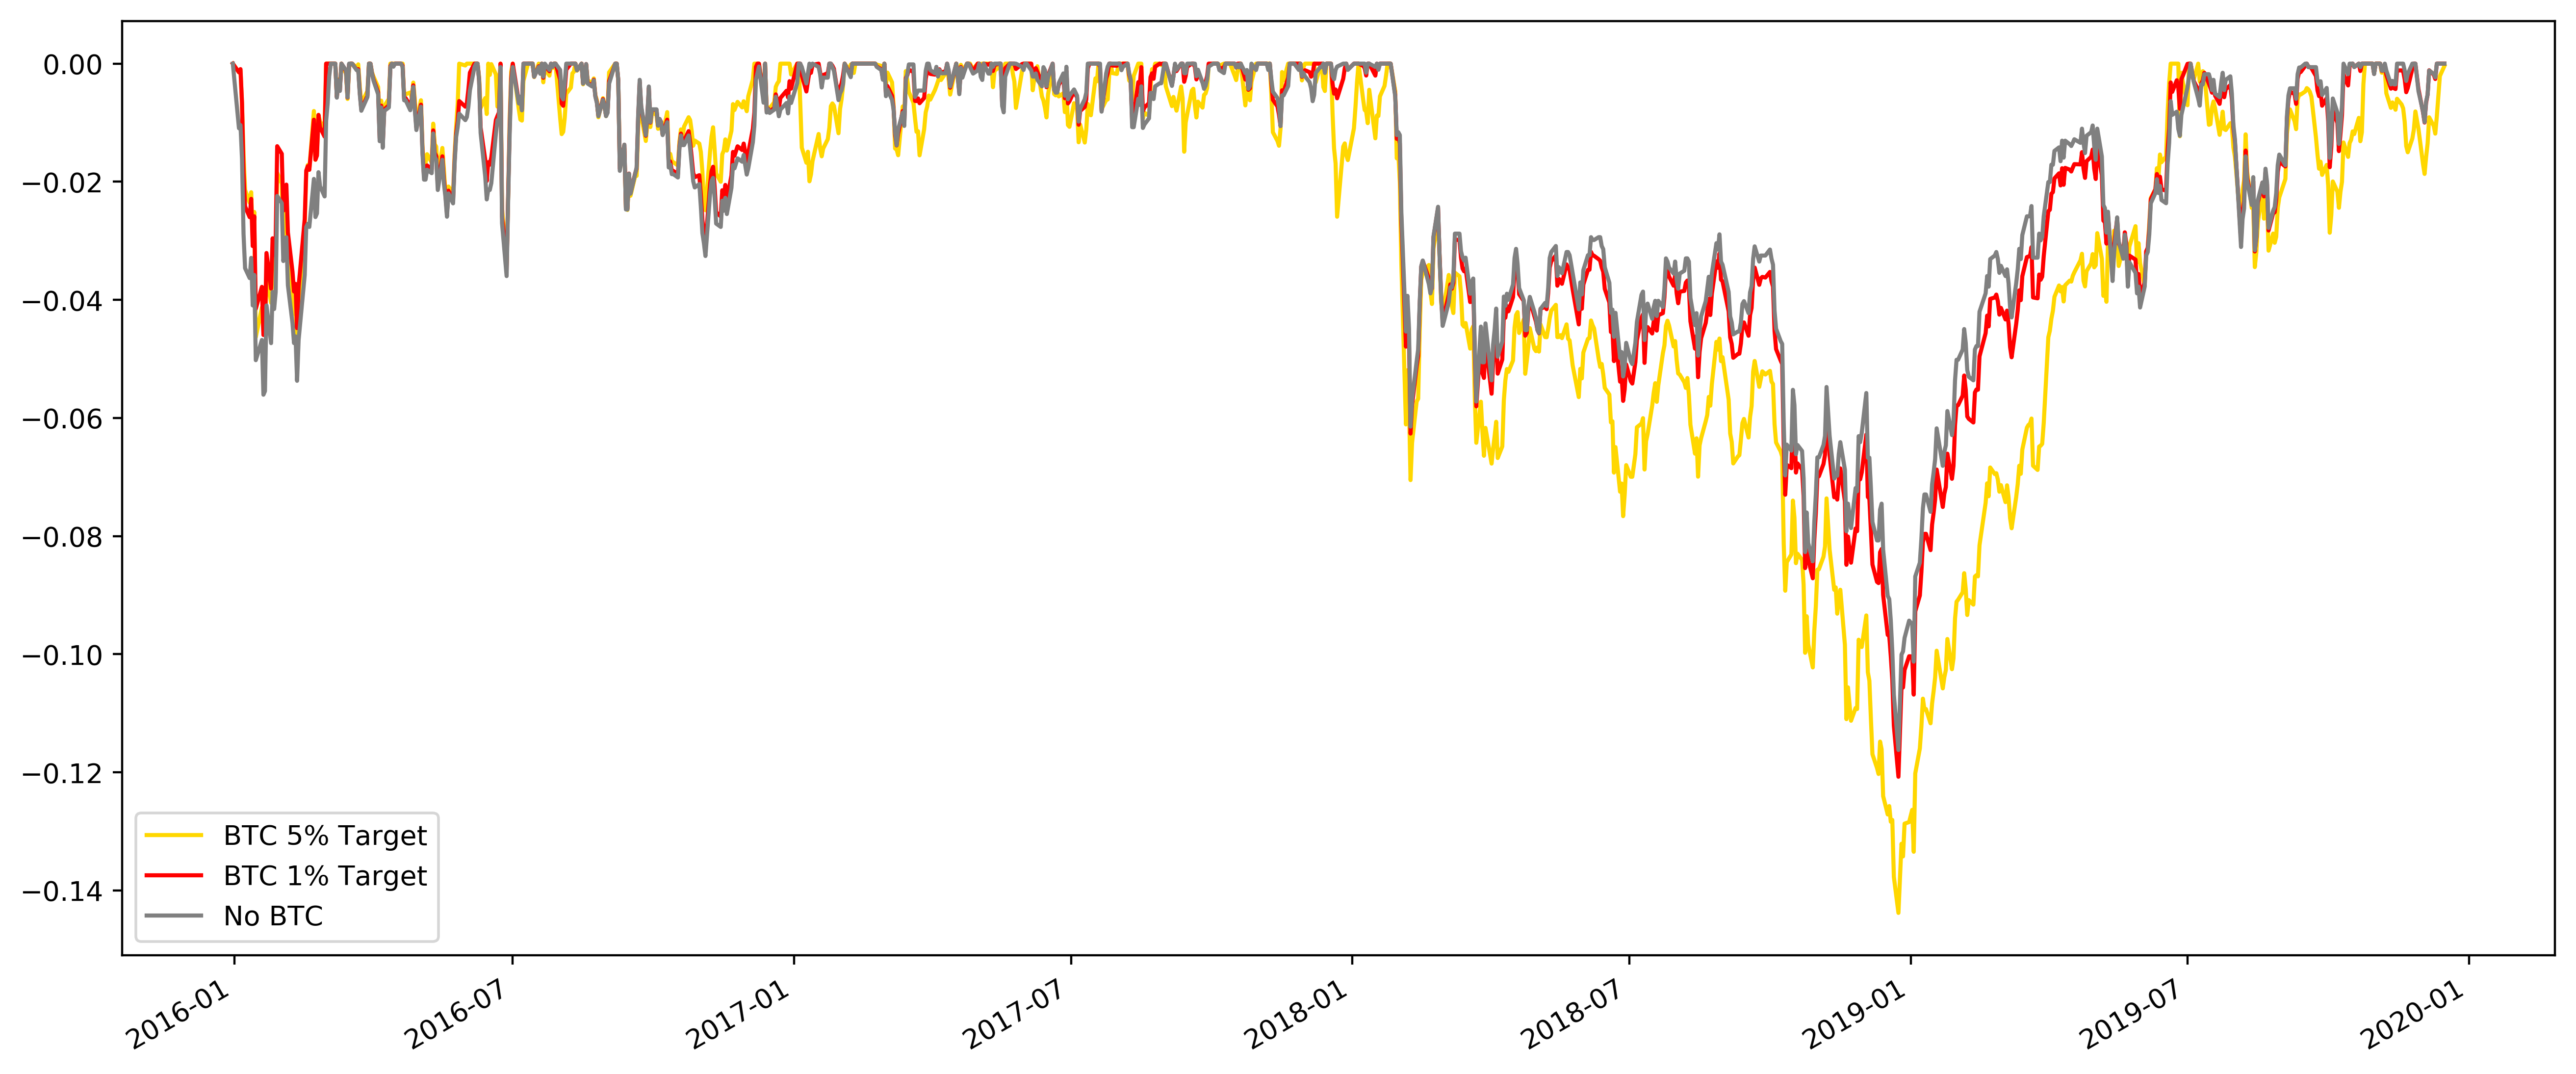

In [138]:
# Plot the results
fig, ax = plt.subplots(figsize=[16, 7])
Daily_Drawdown2.plot(color='gold', label='BTC 5% Target')
Daily_Drawdown1.plot(color='r', label='BTC 1% Target')
Daily_Drawdown3.plot(color='gray', label='No BTC')
plt.legend()
plt.show()

# Просто фонд Vanguard

In [139]:
# Список финансовых инструментов в портфеле
TIKERS = ['VPGDX']

# Данные которые будут использоваться в дальнейшем
COLUMNS = ['open', 'close', 'adjclose']

In [140]:
data = OrderedDict()

for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    print(data[tiker].head())

                 open      close   adjclose
date                                       
2015-12-31  17.330000  17.330000  13.163204
2016-01-01  17.330000  17.330000  13.163204
2016-01-02  17.330000  17.330000  13.163204
2016-01-03  17.330000  17.330000  13.163204
2016-01-04  17.139999  17.139999  13.018887


In [141]:
for tiker in TIKERS:
    data[tiker]['close'] = data[tiker]['adjclose']
    data[tiker]['open'] = data[tiker]['adjclose']
    del data[tiker]['adjclose']
    print(data[tiker].tail())
COLUMNS = ['open', 'close']

                 open      close
date                            
2019-12-12  17.250000  17.250000
2019-12-13  17.309999  17.309999
2019-12-14  17.309999  17.309999
2019-12-15  17.309999  17.309999
2019-12-16  17.379999  17.379999


In [142]:
WEIGHTS = [1]
COMMISSION = 0.001

In [143]:
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))
    
    context.tikers = TIKERS
    context.assets = [context.symbol(symbol) for symbol in context.tikers]
    
    context.weights = WEIGHTS
    context.n_assets = len(context.assets)
    
    context.window = 1
    
    context.rebalance_period = 1000000
    context.time = 0

In [144]:
def handle_data(context, data):
    
    # Закупка и ребаллансировка
    if context.time == 0 or (context.time % context.rebalance_period == 0):
        
        
        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])
            
    
    context.time += 1

In [145]:
perf = zipline.run_algorithm(start=datetime(2015, 12, 31, 0, 0, 0, 0, pytz.utc),
                              end=datetime(2019, 12, 16, 0, 0, 0, 0, pytz.utc),
                              initialize=initialize,
                              capital_base=10000000,
                              handle_data=handle_data,
                              data=panel)

In [146]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)

In [147]:
qf.get_performance_summary(returns)

annual_volatility     0.067272
annualized_returns    0.074630
cumulative_returns    0.329827
max_drawdown         -0.115364
sharpe_ratio          1.103728
sortino_ratio         1.549372
dtype: float64